In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
import os
import sys
sys.path.append("../lib")
from dataUtils import *
import cPickle as pickle
import cv2
from collections import Counter
from scipy.interpolate import UnivariateSpline


In [29]:
#ClassFile = "../Logs/classes.json"
ClassFile = "../Logs/english_label.txt"

#vineScores = "../Logs/sampled_vine_sentibank_final.csv"
vineScores = "../Logs/MVSO_vine_probs_final.csv"
#selfieScores = "../Logs/selfieSentibankProbs.csv"
sentibank_scores = "../Logs/sentibank_baseline_final.csv"

#vineANPs = "../Logs/sampled_vine_ANPS_final.pk"
vineANPs = "../Logs/MVSO_vine_ANPs_final.pk"
#selfiePaths = "../Logs/selfiePaths.txt"

imageNetObjs = "../Logs/sampledvineImagenetObjs2015_1.pk"

#selfiePopularityFile = "../Logs/selfie_dataset.txt"

root = "/datasets/sagarj/vineData/Dataset/"

visitedList = "../Logs/sampledVids.data"

# sentimentFile = "../Logs/ANP_Sentiments.txt"

color_features = "../Logs/vine_features_ordered.csv"

sampled_img_list = "../Logs/sampled_sentibank_image.txt"

revisedSentimentFile = "../Logs/revised_ANP_sentiments.csv"

In [4]:
#Load the Sentibank scores for both selfies and Vines
vineProbs = np.loadtxt(vineScores, delimiter=',')
sentibank_baseline = np.loadtxt(sentibank_scores, delimiter=',')

In [5]:
print vineProbs.shape , sentibank_baseline.shape

(50187, 4342) (5000, 2089)


In [6]:
def get_ANP_ID_List(pickleList):
    ANPs = []
    IDs = []
    for line in pickleList:
        ids = line.split(',')[0].split('/')[5].split('_')[0]
        IDs.append(ids)
        ANPs.append(line.split(',')[1])
    return IDs , ANPs

def get_vid_senti(pickle , index):
    oldId = pickle[index].split(',')[0].split('/')[6].split('_')[0]
    seqDict = dict()
    indexList = []
    sequence = pickle[index].split(',')[0].split('/')[6].split('_')[1].split('.')[0]
    seqDict[int(sequence)] = str(pickle[index].split(',')[1])
    indexList.append(index)
    index+=1
    #print index
    while (index < len(pickle) and (pickle[index].split(',')[0].split('/')[6].split('_')[0] == oldId)):
        sequence = pickle[index].split(',')[0].split('/')[6].split('_')[1].split('.')[0]
        seqDict[int(sequence)] = str(pickle[index].split(',')[1])
        indexList.append(index)
        index += 1
    seqDict['indexList'] = indexList
    return seqDict , oldId , index
    
def get_VID_ANP_List(pickle):
    megaDict = dict()
    i = 0
    print len(pickle)
    while i < len(pickle):           
        subDict , postId , i = get_vid_senti(pickle , i)
        megaDict[int(postId)] = subDict
    return megaDict


def pruneMegaDict(megadict , filterindices):
    filteredList = dict()
    for entry in megadict:
        commns = set(megadict[entry]['indexList']).intersection(filterindices)
        if len(commns) >= 4:
            filteredList[entry] = megadict[entry]
    return filteredList


In [7]:
image_list =[]
with open(sampled_img_list) as f:
    image_list = f.readlines()

true_labels = []
for line in image_list:
    label = line.split('/')[5]
    true_labels.append(label)
    
# f = open(ClassFile ,'r')
# sentibankClasses = json.load(f)
# f.close()

f = open(ClassFile ,'r')
sentibankClasses = f.readlines()
f.close()

In [8]:
sentibank_probs = np.zeros(len(sentibank_baseline))
detected_labels = []
for i in range(sentibank_probs.shape[0]):
    sentibank_probs[i] = sentibank_baseline[i].max()
    detected_labels.append(str(sentibankClasses[np.argmax(sentibank_baseline[i])]))
    
print np.median(sentibank_probs), sentibank_probs.var(), sentibank_probs.mean()

0.0718716159463 0.0234088881327 0.125452709451


In [9]:
maxVecs = np.zeros(len(vineProbs))
for i in range(len(vineProbs)):
    maxVecs[i] = np.max(vineProbs[i])
print np.mean(maxVecs) , np.median(maxVecs) , np.var(maxVecs)

0.0212515007383 0.0154356472194 0.000481780377752


In [10]:
curatedProbs_index = []
for i in range(len(vineProbs)):
    if (vineProbs[i].max() > (np.mean(maxVecs) + np.var(maxVecs) )):
        curatedProbs_index.append(i)

        
print len(curatedProbs_index)

15469


In [11]:

vineList = readLists(vineANPs)
objList = readLists(imageNetObjs)
print curatedProbs_index[5]
print objList[1]

40
/datasets/sagarj/vineData/sampledFrames/1281860887099457536_2.jpg,label,television,


In [12]:
print vineList[0].split(',')[0].split('/')[6].split('_')[0]

1281860887099457536


In [13]:
idList, anpList = get_ANP_ID_List(vineList)

In [14]:
#print idList[1000] , anpList [1000]

In [15]:
sentidict0 = readSentiments()
sentidict = readRevisedSentiments()

In [16]:
print len(sentidict)

4421


In [17]:
# f = open('sentibankANP.csv', 'wb')
# for k,v in sentidict0.iteritems():
#     f.write(k+','+str(v)+'\n')
#     #print k , v
# f.close()

In [18]:
megaDict = get_VID_ANP_List(vineList)

50187


In [19]:
#megaDict[1281867050901532672]['indexList']

In [20]:
filteredDict = pruneMegaDict(megaDict, curatedProbs_index)

In [21]:
print len(filteredDict)

1756


In [22]:
len(megaDict)

6752

In [23]:
postIds = []
for line in vineList:
    arr = line.split('/')
    i = int(arr[6].split('_')[0])
    postIds.append(i)

In [24]:
letter_counts = Counter(postIds)

In [25]:
len(letter_counts)

6752

In [26]:
#Vectors for filtered videos
senti_matrix = np.zeros((len(filteredDict),6))
print senti_matrix.shape
postList = [1]

(1756, 6)


In [27]:
i = 0
misses = 0
postIdFilteredList = []
for entry in filteredDict:
    postIdFilteredList.append(entry)
    for j in range(1,7):
        if j in filteredDict[entry]:
            senti_matrix[i][j-1] = sentidict[filteredDict[entry][j]] if (filteredDict[entry][j] in sentidict) else 0.0
        else:
            senti_matrix[i][j-1] = 0.0
            misses += 1
    i += 1
print misses

39


In [30]:
#Get all post meta data 
dirs,files = walkLevel1Dir(root)
visited = getVisited(visitedList)
selectedPosts = []
allPosts = []

for d in dirs:
    if d in visited:
        dataRoot = root + d
        popular = getPopularFile(dataRoot)
        rec = getRecords(popular)
        allPosts += rec

In [31]:
print len(allPosts)

0


In [ ]:
filteredPosts = dict()
for k in filteredDict:
    for post in allPosts:
        if post['postId'] == k:
            filteredPosts[k] = post
print len(filteredPosts)

In [ ]:
import random
rand_smpl = [ allPosts[i] for i in sorted(random.sample(xrange(len(allPosts)), len(filteredPosts))) ]
print len(rand_smpl)

allLikes = []
allReposts = []
allLoops = []
for rec in rand_smpl:
    allLikes.append(rec['likes']['count'])
    allReposts.append(rec['reposts']['count'])
    allLoops.append(rec['loops']['count'])

In [ ]:
filLikes = []
filReposts = []
filLoops = []
filPosts = []
for k in filteredPosts:
    filLikes.append(np.log(filteredPosts[k]['likes']['count']+1))
    filReposts.append(np.log(filteredPosts[k]['reposts']['count']+1))
    filLoops.append(np.log(filteredPosts[k]['loops']['count']+1))
    filPosts.append(filteredPosts[k])

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.hist(filLikes, 400, normed=1,histtype='step', cumulative=True,linewidth = 3.0,linestyle='dashed')
plt.hist(filReposts, 400, normed=1,histtype='step', cumulative=True,linewidth = 3.0)
plt.title("CDF for Likes and Repost", fontsize = 25)
plt.xlabel("Likes/repost count (Log scale)",fontsize = 25)
plt.ylabel("CDF",fontsize = 25)
plt.legend(['Likes' , 'Reposts'])
plt.show()


In [ ]:
sortedWRTLikesPosts = [x for (y,x) in sorted(zip(filLikes,filPosts))]
sortedWRTRepostsPosts = [x for (y,x) in sorted(zip(filReposts,filPosts))]

In [ ]:
print np.min(filLikes) , np.max(filLikes) , np.min(filReposts) , np.max(filReposts)

In [ ]:
print np.median(filLikes)
print np.median(filReposts)

In [ ]:
print np.corrcoef(filReposts,filLoops)
print np.corrcoef(filLikes,filLoops)
print np.corrcoef(filReposts,filLikes)

In [ ]:
from sklearn.svm import LinearSVR
clf = LinearSVR()

clf.fit(senti_matrix, filReposts) 
print clf.coef_

In [ ]:
num = 50013
print vineList[num]
print objList[num]
print len(megaDict)
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
img = cv2.imread(vineList[num].split(',')[0],1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [ ]:
print senti_matrix[1:10]

In [32]:
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import minkowski

In [33]:
centroid_list = []
id_list = []
for i in range(1 , 12):
    centroids,_ = kmeans(senti_matrix,i)
    idx,_ = vq(senti_matrix,centroids)
    centroid_list.append(centroids)
    id_list.append(idx)

In [34]:
SSE_values = np.zeros(len(id_list))
for i in range(len(centroid_list)):
    for j in range(len(centroid_list[i])):
        vecs = senti_matrix[id_list[i]==j,:]
        #print vecs.shape
        cent = centroid_list[i][j]
        SSE_1 = 0.0
        for vec in vecs:
            SSE_1 = SSE_1 + minkowski(vec,cent,2)
        SSE_values[j] = SSE_values[j] + SSE_1
for i in range(len(SSE_values)):
    SSE_values[i] = SSE_values[i]/(i+1)

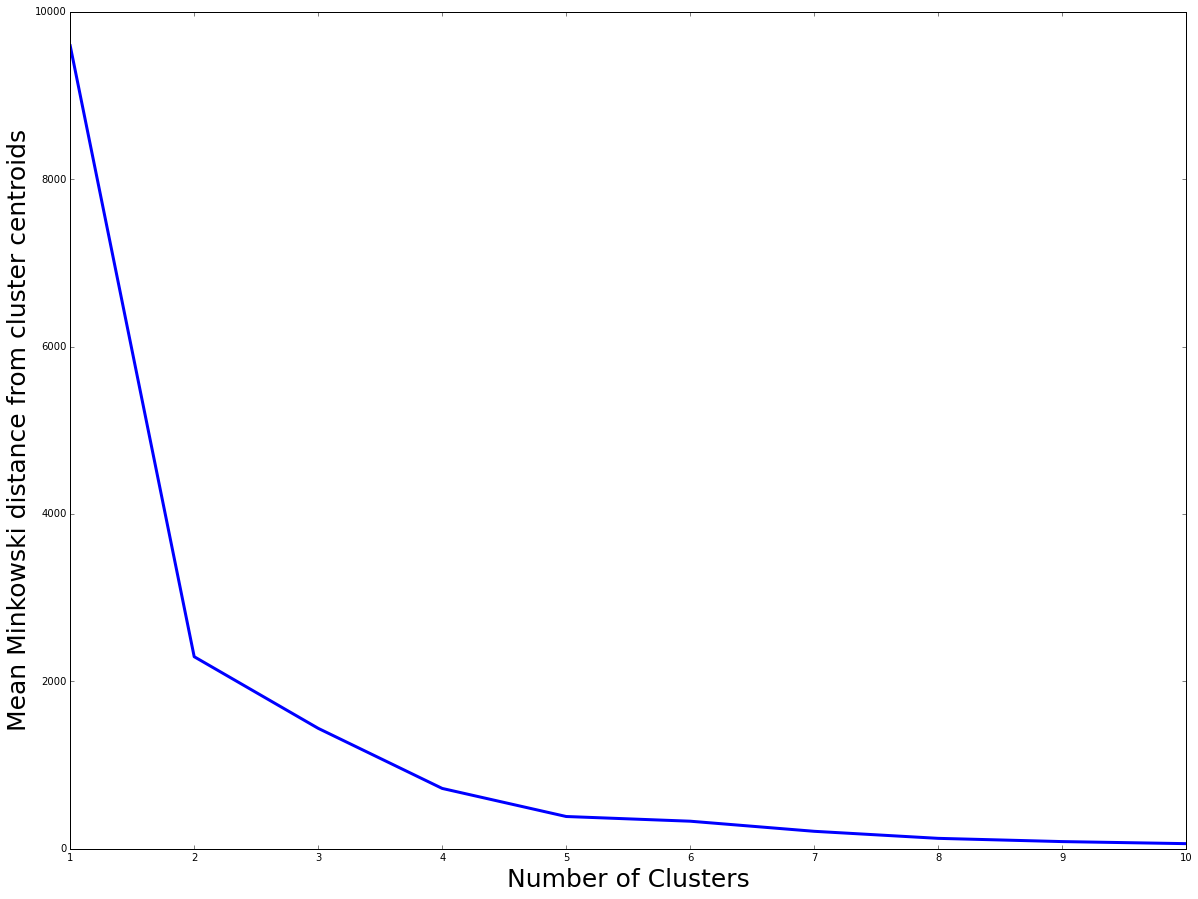

In [35]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
x = np.arange(1,11)
plt.plot(x,SSE_values[:10] ,linewidth = 3.0)
plt.xlabel("Number of Clusters", fontsize = 25)
plt.ylabel("Mean Minkowski distance from cluster centroids", fontsize = 25)
plt.show()

In [36]:
print SSE_values

[ 9594.64747104  2295.15816056  1439.26391704   721.34338638   385.8472741
   329.68208031   209.02180604   124.84482661    86.1360948     61.53899489
    13.93532149]


In [37]:
U, s, V = np.linalg.svd(senti_matrix, full_matrices=False)

In [38]:
print U.shape,  np.diag(s).shape, V.shape
print np.diag(s)

(1756, 6) (6, 6) (6, 6)
[[ 381.06109142    0.            0.            0.            0.            0.        ]
 [   0.           38.82482289    0.            0.            0.            0.        ]
 [   0.            0.           32.020021      0.            0.            0.        ]
 [   0.            0.            0.           29.89079918    0.            0.        ]
 [   0.            0.            0.            0.           27.82291493
     0.        ]
 [   0.            0.            0.            0.            0.
    26.54487607]]


In [39]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(senti_matrix)

PCA(copy=True, n_components=6, whiten=False)

In [40]:
print(pca.explained_variance_ratio_) 

[ 0.57441406  0.13053275  0.08903953  0.0776063   0.06720211  0.06120525]


In [41]:
Modes = np.dot(U,np.diag(s))

In [42]:
indexlist = np.argsort(np.linalg.norm(Modes,axis=1))
sorted_modes = Modes[indexlist]

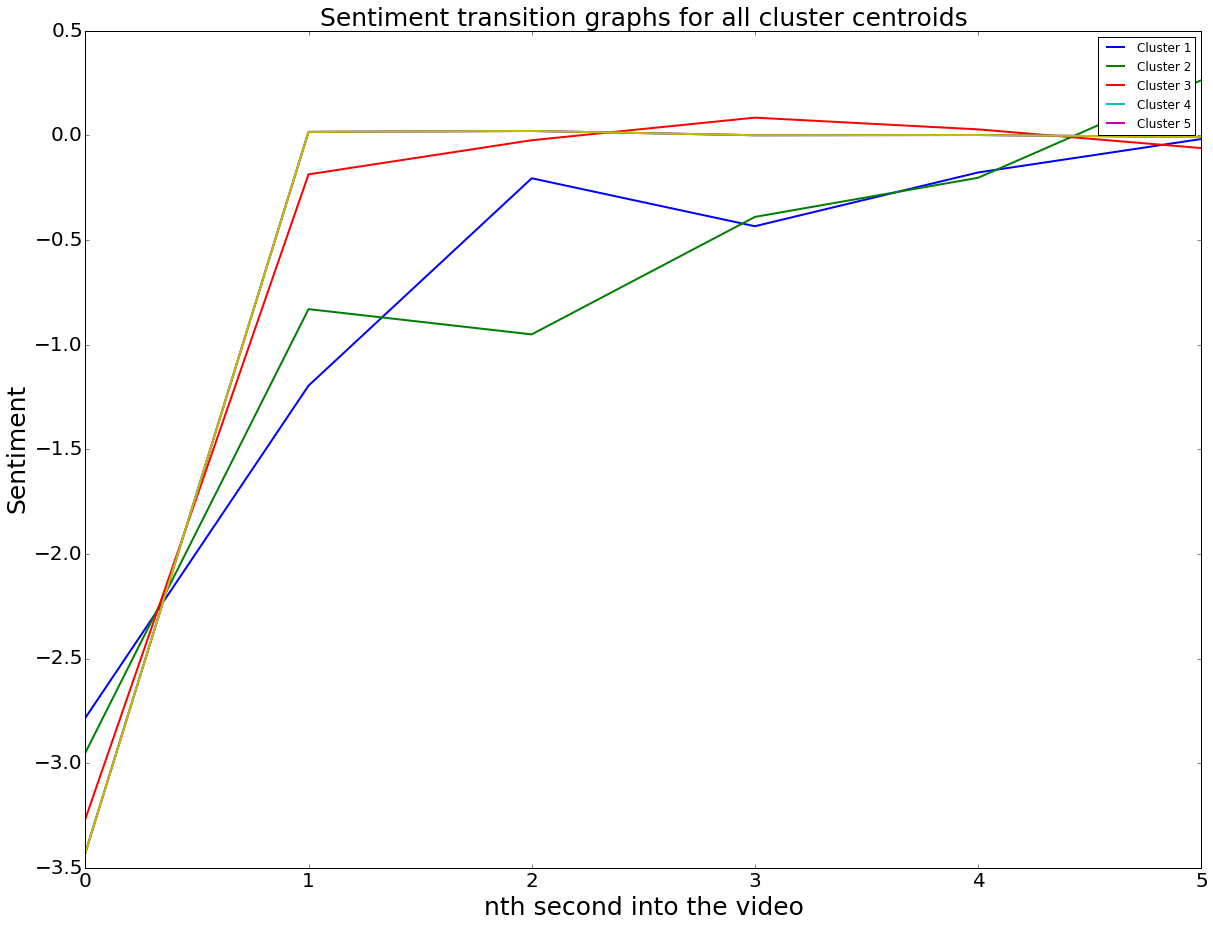

In [43]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.title("Sentiment transition graphs for all cluster centroids", fontsize = 25)
plt.plot(sorted_modes[0], linewidth = 2.0)
plt.plot(sorted_modes[1], linewidth = 2.0)
plt.plot(sorted_modes[2], linewidth = 2.0)
plt.plot(sorted_modes[3], linewidth = 2.0)
plt.plot(sorted_modes[4], linewidth = 2.0 )
plt.plot(sorted_modes[5], linewidth = 2.0 )
# plt.plot(centroid_final[6], linewidth = 2.0 )

plt.xlabel("nth second into the video", fontsize = 25)
plt.ylabel("Sentiment", fontsize = 25)
plt.legend(['Cluster 1', 'Cluster 2' , 'Cluster 3' 
            ,'Cluster 4'
            ,'Cluster 5'
            #,'Cluster 6'
            #,'Cluster 7'
            
           ])
plt.show()

In [44]:
centroid_final,_ = kmeans(senti_matrix,4)
idx_final,_ = vq(senti_matrix,centroid_final)

In [45]:
vecs1 = senti_matrix[idx_final==0,:]
vecs2 = senti_matrix[idx_final==1,:]
vecs3 = senti_matrix[idx_final==2,:]
vecs4 = senti_matrix[idx_final==3,:]
vecs5 = senti_matrix[idx_final==4,:]
vecs6 = senti_matrix[idx_final==5,:]
vecs7 = senti_matrix[idx_final==6,:]
#senti_matrix[idx_final==0]

In [53]:
vars1 = [np.var(vecs1[:,1]) for i in range(vecs1.shape[1])]
print vars1
vars2 = [np.var(vecs2[:,1]) for i in range(vecs2.shape[1])]
print vars2
vars3 = [np.var(vecs3[:,1]) for i in range(vecs3.shape[1])]
print vars3
vars4 = [np.var(vecs4[:,1]) for i in range(vecs4.shape[1])]
print vars4

[0.72348205245373576, 0.72348205245373576, 0.72348205245373576, 0.72348205245373576, 0.72348205245373576, 0.72348205245373576]


In [46]:
print len(vecs1)
print len(vecs2)
print len(vecs3)
print len(vecs4)
print len(vecs5)
print len(vecs6)
print len(vecs7)

221
467
488
580
0
0
0


In [47]:
print centroid_final

[[ 2.36043706  2.32316434  2.16292832  2.20521853  2.1702364   2.01020105]
 [ 3.60470648  3.6842831   3.92507892  4.03513439  3.87583486  3.30432778]
 [ 3.23607333  3.09909726  3.17723577  3.02506801  3.07601626  3.36413757]
 [ 4.48078417  4.49620188  4.43484848  4.41896149  4.45972057  4.52492644]]


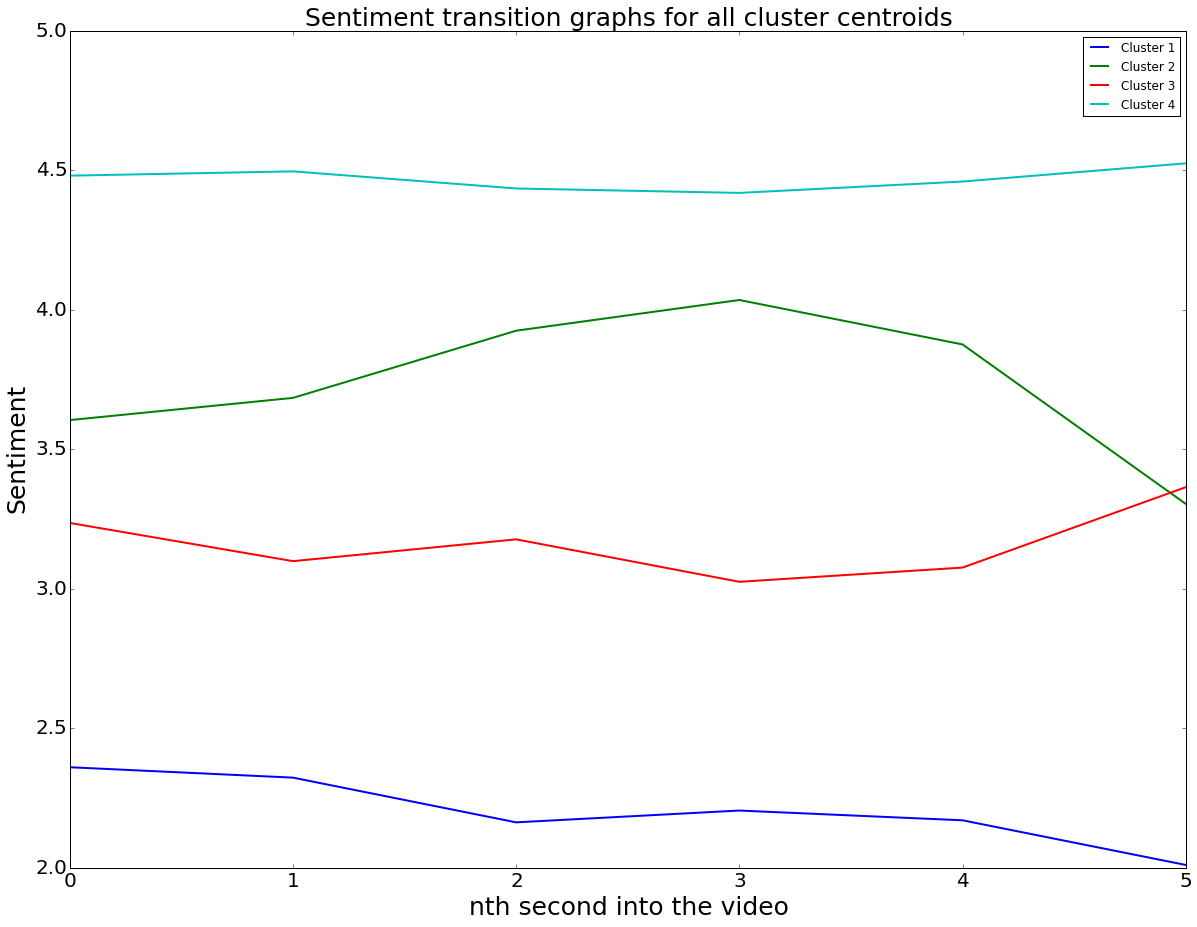

In [49]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.title("Sentiment transition graphs for all cluster centroids", fontsize = 25)
plt.plot(centroid_final[0], linewidth = 2.0)
plt.plot(centroid_final[1], linewidth = 2.0)
plt.plot(centroid_final[2], linewidth = 2.0)
plt.plot(centroid_final[3], linewidth = 2.0)
#plt.plot(centroid_final[4], linewidth = 2.0 )
# plt.plot(centroid_final[5], linewidth = 2.0 )
# plt.plot(centroid_final[6], linewidth = 2.0 )

plt.xlabel("nth second into the video", fontsize = 25)
plt.ylabel("Sentiment", fontsize = 25)
plt.legend(['Cluster 1', 'Cluster 2' , 'Cluster 3' 
            ,'Cluster 4'
            #,'Cluster 5'
            #,'Cluster 6'
            #,'Cluster 7'
            
           ])
plt.show()

In [ ]:
def filterCluster(postids , posts , postDict, clusterMems , clusterId ):
    plist = []
    ANP_list = []
    selective = clusterMems == clusterId
    ids = [i for (i, v) in zip(postids, selective) if v]
    for postid in ids:
        plist.append(posts[postid])
        ANP_list.append(postDict[postid])
    return plist , ANP_list

def likesRepostsLoops(cluster):
    likes = np.zeros(len(cluster))
    reposts = np.zeros(len(cluster))
    loops = np.zeros(len(cluster))
    for i in range(len(cluster)):
        likes[i] = np.log(cluster[i]['likes']['count']+1)
        reposts[i] = np.log(cluster[i]['reposts']['count']+1)
        loops[i] = np.log(cluster[i]['loops']['count']+1)
    return likes, reposts, loops


In [ ]:
cluster1 , ANP_cluster1 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,idx_final,0)
print len(cluster1)
cluster2 , ANP_cluster2 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,idx_final,1)
print len(cluster2)
cluster3 , ANP_cluster3 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,idx_final,2)
print len(cluster3)
cluster4 , ANP_cluster4 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,idx_final,3)
print len(cluster4)
cluster5 , ANP_cluster5 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,idx_final,4)
print len(cluster5)

In [ ]:
likesC1 , repostsC1 , loopsC1 = likesRepostsLoops(cluster1)
likesC2 , repostsC2 , loopsC2 = likesRepostsLoops(cluster2)
likesC3 , repostsC3 , loopsC3 = likesRepostsLoops(cluster3)
likesC4 , repostsC4 , loopsC4 = likesRepostsLoops(cluster4)
likesC5 , repostsC5 , loopsC5 = likesRepostsLoops(cluster5)

In [ ]:
# likesC1 = likesC1/len(senti_matrix)
# likesC2 = likesC2/len(senti_matrix)
# likesC3 = likesC3/len(senti_matrix)
# likesC4 = likesC4/len(senti_matrix)
# likesC5 = likesC1/len(senti_matrix)


In [ ]:
c1 = np.random.choice(len(likesC1), 50)
sampledLikesC1 = likesC1[c1]

c2 = np.random.choice(len(likesC2), 50)
sampledLikesC2 = likesC2[c2]

c3 = np.random.choice(len(likesC3), 50)
sampledLikesC3 = likesC3[c3]

c4 = np.random.choice(len(likesC4), 50)
sampledLikesC4 = likesC4[c4]

c5 = np.random.choice(len(likesC5), 50)
sampledLikesC5 = likesC5[c5]


In [ ]:
print "Numbers for Cluster C1: Median Reposts: %f , Mean Reposts: %f , Median Likes: %f , \
Mean Likes: %f , Median Loops: %f , Mean Loops \
%f"%(np.median(repostsC1),np.mean(repostsC1),np.median(sampledLikesC1),np.mean(sampledLikesC1),np.median(loopsC1),np.mean(loopsC1))

print "Numbers for Cluster C2: Median Reposts: %f , Mean Reposts: %f , Median Likes: %f , \
Mean Likes: %f , Median Loops: %f , Mean Loops \
%f"%(np.median(repostsC2),np.mean(repostsC2),np.median(sampledLikesC2),np.mean(sampledLikesC2),np.median(loopsC2),np.mean(loopsC2))

print "Numbers for Cluster C3: Median Reposts: %f , Mean Reposts: %f , Median Likes: %f , \
Mean Likes: %f , Median Loops: %f , Mean Loops \
%f"%(np.median(repostsC3),np.mean(repostsC3),np.median(sampledLikesC3),np.mean(sampledLikesC3),np.median(loopsC3),np.mean(loopsC3))

print "Numbers for Cluster C4: Median Reposts: %f , Mean Reposts: %f , Median Likes: %f , \
Mean Likes: %f , Median Loops: %f , Mean Loops \
%f"%(np.median(repostsC4),np.mean(repostsC4),np.median(sampledLikesC4),np.mean(sampledLikesC4),np.median(loopsC4),np.mean(loopsC4))

print "Numbers for Cluster C5: Median Reposts: %f , Mean Reposts: %f , Median Likes: %f , \
Mean Likes: %f , Median Loops: %f , Mean Loops \
%f"%(np.median(repostsC5),np.mean(repostsC5),np.median(sampledLikesC5),np.mean(sampledLikesC5),np.median(loopsC5),np.mean(loopsC5))

In [ ]:
clf = LinearSVR()

clf.fit(vecs3, repostsC3) 
print clf.coef_

In [ ]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15, 10)
# plt.hist(likesC1, 400, normed=1,histtype='step', cumulative=False,linewidth = 3.0,linestyle='dashed')
# plt.hist(likesC2, 400, normed=1,histtype='step', cumulative=False,linewidth = 3.0)
# plt.hist(likesC3, 400, normed=1,histtype='step', cumulative=False, linewidth = 3.0,linestyle='dotted')
# plt.hist(likesC4, 400, normed=1,histtype='step', cumulative=False, linewidth = 3.0,linestyle='dotted')
# plt.hist(likesC5, 400, normed=1,histtype='step', cumulative=True, linewidth = 3.0,linestyle='dotted')
# plt.title("CDF for Likes for the 4 sentiment clusters ", fontsize = 25)
# plt.xlabel("Likes/repost count",fontsize = 25)
# plt.ylabel("CDF",fontsize = 25)
# plt.legend(['Likes C1', 'Likes C2' , 'Likes C3' , 'Likes C4'])
# plt.show()

In [ ]:

def plotDist(RV, samples, b):
    N = samples 
    n = b
    s = np.random.normal(size=N)   # generate your data sample with N elements
    p1, x1 = np.histogram(RV, bins=n) # bin it into n = N/10 bins
    xs1 = x1[:-1] + (x1[1] - x1[0])/2
    f1 = UnivariateSpline(xs1, p1)
    plt.plot(xs1 , f1(xs1) ,'-')

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plotDist(sampledLikesC1 , 1000 , 50)
plotDist(sampledLikesC2 , 1000 , 50)
plotDist(sampledLikesC3 , 1000 , 50)
plotDist(sampledLikesC4 , 1000 , 50)
plotDist(sampledLikesC5 , 1000 , 50)
plt.legend(['Reposts C1', 'Reposts C2' , 'Reposts C3' , 'Reposts C4', 'Reposts C4'])
plt.xlabel("Like count per video per cluster in Log scale",fontsize = 25)
plt.ylabel("Frequency ",fontsize = 25)
plt.show()

In [ ]:

# fig, ax = plt.subplots()
# fig.set_size_inches(15, 10)
# N = 1000
# n = N/50
# s = np.random.normal(size=N)   # generate your data sample with N elements
# p1, x1 = np.histogram(repostsC1, bins=n) # bin it into n = N/10 bins
# p2, x2 = np.histogram(repostsC2, bins=n) # bin it into n = N/10 bins
# p3, x3 = np.histogram(repostsC3, bins=n) # bin it into n = N/10 bins
# p4, x4 = np.histogram(repostsC4, bins=n) # bin it into n = N/10 bins

# xs1 = x1[:-1] + (x1[1] - x1[0])/2   # convert bin edges to centers
# xs2 = x2[:-1] + (x2[1] - x2[0])/2   # convert bin edges to centers
# xs3 = x3[:-1] + (x3[1] - x3[0])/2   # convert bin edges to centers
# xs4 = x4[:-1] + (x4[1] - x4[0])/2   # convert bin edges to centers

# f1 = UnivariateSpline(xs1, p1)
# f2 = UnivariateSpline(xs2, p2)
# f3 = UnivariateSpline(xs3, p3)
# f4 = UnivariateSpline(xs4, p4)

# plt.plot(xs1, f1(xs1) ,'.-')
# plt.plot(xs2, f2(xs2) ,'.-')
# plt.plot(xs3, f3(xs3) ,'.-')
# plt.plot(xs4, f4(xs4) ,'.-')

# plt.legend(['Reposts C1', 'Reposts C2' , 'Reposts C3' , 'Reposts C4'])
# plt.show()

In [ ]:
# import numpy as np
# from scipy.interpolate import UnivariateSpline
# from matplotlib import pyplot as plt

# fig, ax = plt.subplots()
# fig.set_size_inches(15, 10)
# N = 1000
# n = N/10
# p, x1 = np.histogram(repostsC1, bins=n) # bin it into n = N/10 bins
# p, x2 = np.histogram(repostsC2, bins=n) # bin it into n = N/10 bins
# p, x3 = np.histogram(repostsC3, bins=n) # bin it into n = N/10 bins
# x1 = x1[:-1] + (x1[1] - x1[0])/2   # convert bin edges to centers
# x2 = x2[:-1] + (x2[1] - x2[0])/2   # convert bin edges to centers
# x3 = x3[:-1] + (x3[1] - x3[0])/2   # convert bin edges to centers
# f = UnivariateSpline(x, p, s=n)
# plt.plot(x1, f(x1))
# plt.plot(x2, f(x2))
# plt.plot(x3, f(x3))
# plt.show()

In [ ]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15, 10)
# N = 1000
# n = N/10
# p, x1 = np.histogram(likesC1, bins=n) # bin it into n = N/10 bins
# p, x2 = np.histogram(likesC2, bins=n) # bin it into n = N/10 bins
# p, x3 = np.histogram(likesC3, bins=n) # bin it into n = N/10 bins
# #x1 = x1[:-1] + (x1[1] - x1[0])/2   # convert bin edges to centers
# #x2 = x2[:-1] + (x2[1] - x2[0])/2   # convert bin edges to centers
# #x3 = x3[:-1] + (x3[1] - x3[0])/2   # convert bin edges to centers
# f = UnivariateSpline(x, p, s=n)
# plt.plot(x1, f(x1))
# plt.plot(x2, f(x2))
# plt.plot(x3, f(x3))
# plt.show()

In [ ]:
# from numpy import linspace,exp
# from numpy.random import randn
# import matplotlib.pyplot as plt
# from scipy.interpolate import UnivariateSpline
# x = linspace(-3, 3, 100)
# y = exp(-x**2) + randn(100)/10
# s = UnivariateSpline(x, y, s=1)
# xs = linspace(-3, 3, 1000)
# ys = s(xs)
# plt.plot(x, y, '.-')
# plt.plot(xs, ys)
# plt.show()

In [ ]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15, 10)
# plt.hist(repostsC1, 400, normed=1,histtype='step', cumulative=True,linewidth = 3.0,linestyle='dashed')
# plt.hist(repostsC2, 400, normed=1,histtype='step', cumulative=True,linewidth = 3.0)
# plt.hist(repostsC3, 400, normed=1,histtype='step', cumulative=True, linewidth = 3.0,linestyle='dotted')
# #plt.hist(repostsC4, 400, normed=1,histtype='step', cumulative=True, linewidth = 3.0,linestyle='dotted')
# plt.title("CDF for Reposts for the 4 sentiment clusters ", fontsize = 25)
# plt.xlabel("Repost count",fontsize = 25)
# plt.ylabel("CDF",fontsize = 25)
# plt.legend(['Reposts C1', 'Reposts C2' , 'Reposts C3' , 'Reposts C4'])
# plt.show()

In [ ]:
# print np.std(repostsC1) , np.std(repostsC2), np.std(repostsC3), np.std(repostsC4)#, np.std(repostsC5)

# print np.std(likesC1) , np.std(likesC2), np.std(likesC3), np.std(likesC4)#, np.std(likesC5)

In [ ]:
# print senti_matrix[52]
# print postIdFilteredList[52]
# print filteredDict[postIdFilteredList[52]]
# print filteredPosts[postIdFilteredList[52]]

In [ ]:
import io
import base64
from IPython.display import HTML

num = 155
url = cluster1[num]['videoDashUrl'].strip().split('/')[-1].split('?')[0]
print  cluster1[num]['videoDashUrl']
print ANP_cluster1[num]

#print url
videoPath = "/datasets/sagarj/vineData/Dataset/Videos/" + url
print videoPath


video = io.open(videoPath, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In [ ]:
def readFeatures(lines):
    ids = []
    features = []
    feats = []
    
    components = lines[0].strip().split(',')
    ID = components[0].split('/')[1].strip().split('_')[0]
    
    for line in lines:
        components = line.strip().split(',')
        postId = components[0].split('/')[1].strip().split('_')[0]
        if postId != ID:
            ids.append(postId)
            ID = postId
            #Take median of all frames in a vine for all the attributes
            features.append(np.median(feats,0))
            feats[:] = []
            feats.append([float(x) for x in components[1:]]) 
        else :
            feats.append([float(x) for x in components[1:]]) 
            
    return features, ids
    

In [ ]:
with open(color_features) as g:
    featureLines = g.readlines()
print len(featureLines)

In [ ]:
featureLines[6].strip().split('|')[1:]

In [ ]:
features , posts = readFeatures(featureLines)

In [ ]:
print len(posts) , len(features)

In [ ]:
aes_features = np.asarray(features)
print aes_features.shape

In [ ]:
# aes_centroid_list = []
# aes_id_list = []
# for i in range(1 , 12):
#     centroids,_ = kmeans(aes_features,i)
#     idx,_ = vq(aes_features,centroids)
#     aes_centroid_list.append(centroids)
#     aes_id_list.append(idx)

In [ ]:

# SSE_values = np.zeros(len(aes_id_list))
# for i in range(len(aes_centroid_list)):
#     for j in range(len(aes_centroid_list[i])):
#         vecs = aes_features[aes_id_list[i]==j,:]
#         #print vecs.shape
#         cent = aes_centroid_list[i][j]
#         SSE_1 = 0.0
#         for vec in vecs:
#             SSE_1 = SSE_1 + minkowski(vec,cent,2)
#         SSE_values[j] = SSE_values[j] + SSE_1
# for i in range(len(SSE_values)):
#     SSE_values[i] = SSE_values[i]/(i+1)

# fig, ax = plt.subplots()
# fig.set_size_inches(20, 15)
# plt.rc('xtick', labelsize=20) 
# plt.rc('ytick', labelsize=20)
# x = np.arange(1,11)
# plt.plot(x,SSE_values[:10])
# plt.xlabel("Number of Clusters", fontsize = 25)
# plt.ylabel("Minkowski distance from cluster centroids", fontsize = 25)
# plt.title("")
# plt.show()

In [ ]:
# aes_centroid_final,_ = kmeans(aes_features,4)
# aes_idx_final,_ = vq(aes_features,aes_centroid_final)

In [ ]:
# aes_cluster1 , ANP_cluster1 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,aes_idx_final,0)
# print len(aes_cluster1)
# aes_cluster2 , ANP_cluster2 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,aes_idx_final,1)
# print len(aes_cluster2)
# aes_cluster3 , ANP_cluster3 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,aes_idx_final,2)
# print len(aes_cluster3)
# aes_cluster4 , ANP_cluster4 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,aes_idx_final,3)
# print len(aes_cluster4)

In [ ]:
# import io
# import base64
# from IPython.display import HTML

# num = 50
# url = aes_cluster4[num]['videoDashUrl'].strip().split('/')[-1].split('?')[0]
# print  aes_cluster4[num]['videoDashUrl']
# print ANP_cluster4[num]
# #print url
# videoPath = "/datasets/sagarj/vineData/Dataset/Videos/" + url
# #print videoPath


# video = io.open(videoPath, 'r+b').read()
# encoded = base64.b64encode(video)
# HTML(data='''<video alt="test" controls>
#                 <source src="data:video/mp4;base64,{0}" type="video/mp4" />
#              </video>'''.format(encoded.decode('ascii')))

In [ ]:
#print aes_centroid_final

In [ ]:

print cluster1[0]['postId']
print posts.index(str(cluster1[0]['postId']))

In [ ]:
def getAesFeatures(cluster, posts , numpyFeatures):
    indices = []
    for c in cluster:
        i = posts.index(str(c['postId']))
        if i:
            indices.append(i)
    features = numpyFeatures[indices]
    return features

In [ ]:
Aes1 = getAesFeatures(cluster1, posts , aes_features)
Aes2 = getAesFeatures(cluster2, posts , aes_features)
Aes3 = getAesFeatures(cluster3, posts , aes_features)
Aes4 = getAesFeatures(cluster4, posts , aes_features)
Aes5 = getAesFeatures(cluster5, posts , aes_features)

In [ ]:
print Aes1.shape
print Aes2.shape
print Aes3.shape
print Aes4.shape
print Aes5.shape

In [ ]:
# print Aes1

In [ ]:
plt.plot(Aes2[:,9])
plt.show()

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plotDist(Aes1[:,10]/len(Aes1) , 1000 , 50)
plotDist(Aes2[:,10]/len(Aes2) , 1000 , 50)
plotDist(Aes3[:,10]/len(Aes3) , 1000 , 50)
plotDist(Aes4[:,10]/len(Aes4) , 1000 , 50)
plotDist(Aes5[:,10]/len(Aes5) , 1000 , 50)
plt.legend(['Reposts C1', 'Reposts C2' , 'Reposts C3' , 'Reposts C4', 'Reposts C5'])
plt.show()